In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

my_path = '/content/notebooks'
# Colab Notebooks 안에 my_env 폴더에 패키지 저장
os.symlink('/content/drive/My Drive/Colab Notebooks/my_env', my_path)
sys.path.insert(0, my_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FileExistsError: ignored

In [ ]:
!pip install scipy==1.8.1 --no-deps
!pip install pandas==1.5.3 --no-deps

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import scipy
print(scipy.__version__)

1.8.1


In [ ]:
import pandas
print(pandas.__version__)

1.5.3


### Performance evaluation function for classification

* Confusion Matrix
    ||Predicted False|Predicted True|
    |:---:|:---:|:---:|
    |**Actual False**|True Negative(TN)|False Positive(FP)|
    |**Actual True**|False Negatvie(FN)|True Positive(TP)|  
<br>
    
* Metric  
    `sklearn.metrics에 이미 존재하는 지표도 있으나 실습 차원에서 직접 지표 계산`
    * TPR(True Positive Rate, Recall) $= \frac{TP}{FN+TP}$  
    * Precision $= \frac{TP}{FP+TP}$  
    * TNR(True Negative Rate) $= \frac{TN}{FP+TN}$  
    * Accuracy $= \frac{TP+TN}{TN+FP+FN+TP}$  
    * BCR(Balanced Correction Rate) $= \sqrt{\frac{TP}{FN+TP} \cdot \frac{TN}{FP+TN}}$  
    * F1 $= \frac{2 \cdot TPR \cdot Precision}{TPR+Precision}$  

    


In [ ]:
from typing import Union
import numpy as np
from sklearn.metrics import *


def perf_eval_clf(y_true: Union[np.array,list], y_pred: Union[np.array,list])->list:
    """
    Input:
    y_true : ndarray of shape (n_samples,)
    y_pred : ndarray of shape (n_samples,)

    Return:
    [TPR,Precision,TNR, Accuracy, BCR, F1]: scores of classification in a list
    """
    cm = confusion_matrix(y_true = y_true, y_pred = y_pred)
    print(f"Confusion Matrix:\n{cm}")
    tn, fp, fn, tp = cm.ravel()
    TPR = recall_score(y_true, y_pred)
    PRE = precision_score(y_true, y_pred)
    TNR = round(tn/(fp+tn),3)
    ACC = accuracy_score(y_true, y_pred)
    BCR = balanced_accuracy_score(y_true, y_pred)
    F1 = f1_score(y_true, y_pred)

    
    return [TPR,PRE,TNR,ACC,BCR,F1]

### Intialize a performance summary table

* R에서는 table 형태로 다루어졌음  
* Python에서는 dictionary로 결과를 저장하고 결과 확인 시 DataFrame으로 출력  
* 데이터 셋 간의 비교가 아닌 Personla Loan 데이터 셋에 대한 8 가지의 Logistic Regression 모델 결과 비교

In [ ]:
import pandas as pd

def display_result(result_dict: dict, metric_names: list = ['TPR(Recall)','Precision','TNR','ACC','BCR','F1']):
    """
    Input:
    result_dict : 데이터 셋 별 classification 평가 결과 저장한 dictionary
    ex) {'Personal Loan':[0.1,0.5,0.3],...}
    

    metric_names : Classification 평가 지표 이름 List
    ex) ['TPR(Recall)','Precision','TNR','ACC','BCR','F1']
    """
    result_df = pd.DataFrame(result_dict).T
    result_df.index = list(result_dict.keys())
    result_df.columns = metric_names
    
    display(result_df)

result_dict= {}

In [ ]:
def display_coefs(model,name:str)->None:
    """
    Input:
    model: Fitted model with given variables
    name: Name of the model
    """
    features = ['Constant']+model.feature_names_in_.tolist() if model.intercept_ else model.feature_names_in_.tolist()
    coefs = [model.intercept_[0]]+model.coef_[0].tolist() if model.intercept_ else model.coef_[0].tolist()  
    print(f'Model: {name}')
    display(pd.DataFrame({'features':features,'coefs':coefs}))

### Data Load and Preprocessing (heart_failure_clinical_records_dataset.csv)
* Google Drive Mount
<br>
* Select the relevant variables  

* Normalize the input data
    * scale 함수 주요 parameters  
        (1) axis: 0 - 각 feature 내에서 scale 진행 / 1 - 각 샘플 내에서 scale 진행  
        (2) with_mean: Zero Centering 진행 유무  
        (3) with_std: 표준편차로 나누어줌으로써 범위 일정하게 맞춤 

In [ ]:
from sklearn.preprocessing import scale

heart = pd.read_csv("/content/drive/MyDrive/수업/4학년/1학기/다변량분석/과제_다변량/heart_failure_clinical_records_dataset.csv")

# Indices for the activated input variables 

#input_idx = set(range(len(heart.columns.to_list())))-set([0,4,9])
#input_idx = list(input_idx)
input_idx = range(len(heart.columns.to_list()))
target_idx = 12
max_features = len(input_idx)

heart_input = heart.iloc[:,input_idx]
heart_input_scaled = scale(heart_input,axis =0, with_mean=True, with_std=True)
heart_target = heart.iloc[:,target_idx]
heart_data = pd.concat((heart_input,heart_target),axis=1)

conti_idx = [0, 2, 4, 6, 7, 8, 11]
heart_conti = heart.iloc[:,conti_idx]

# Remove Null and unnecessary variables
heart = heart.dropna()
heart



,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


###Univariate Statistics and Box Plot
* 각 입력 변수의 Mean, Standard deviation, Skewness, Kurtosis 구하기
* Box Plot 도시

In [ ]:
# Univariate Statistics
from scipy.stats import skew, kurtosis

df = pd.DataFrame(columns = ['Attribute', 'mean','std','skewness', 'kurtosis'])


def uni_stats(x):

  # 평균
  avg = x.mean()
  # 표준 편차
  std = x.std()

  # 첨도
  kurto = kurtosis(x)
  # 왜도
  skewness = skew(x)

  
  return avg, std, kurto, skewness

df.loc[0] = ['age'] + list(uni_stats(heart['age']))
df.loc[1] = ['creatinine_phosphokinase'] + list(uni_stats(heart['creatinine_phosphokinase']))
df.loc[2] = ['ejection_fraction'] + list(uni_stats(heart['ejection_fraction']))
df.loc[3] = ['platelets'] + list(uni_stats(heart['platelets']))
df.loc[4] = ['serum_creatinine'] + list(uni_stats(heart['serum_creatinine']))
df.loc[5] = ['serum_sodium'] + list(uni_stats(heart['serum_sodium']))
df.loc[6] = ['time'] + list(uni_stats(heart['time']))

df

,Attribute,mean,std,skewness,kurtosis
0,age,60.833893,11.894809,-0.201793,0.420937
1,creatinine_phosphokinase,581.839465,970.287881,24.710458,4.440689
2,ejection_fraction,38.083612,11.834841,0.020720,0.552593
3,platelets,263358.029264,97804.236869,6.085906,1.454975
4,serum_creatinine,1.393880,1.034510,25.378346,4.433610
5,serum_sodium,136.625418,4.412477,4.031142,-1.042870
6,time,130.260870,77.614208,-1.211874,0.127161


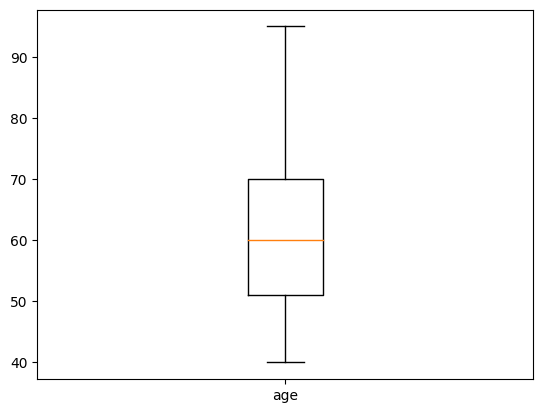

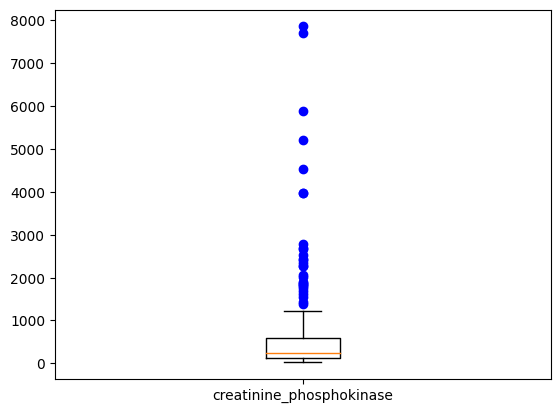

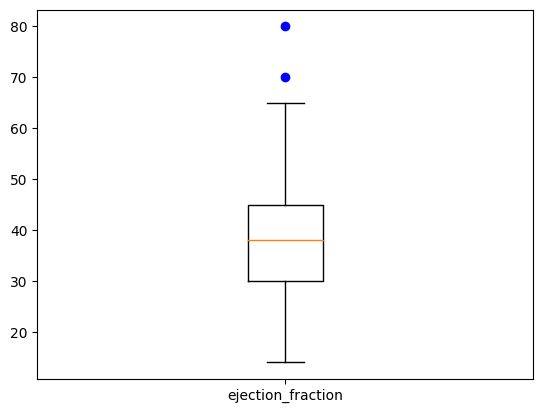

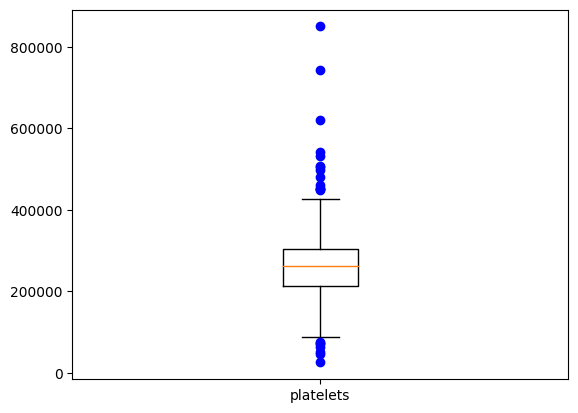

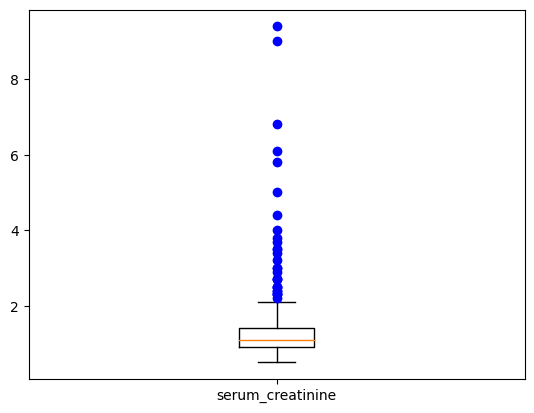

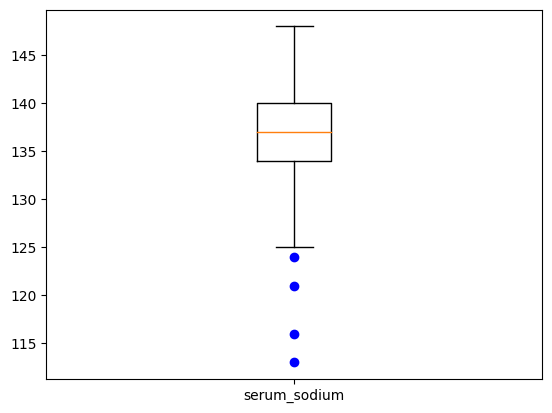

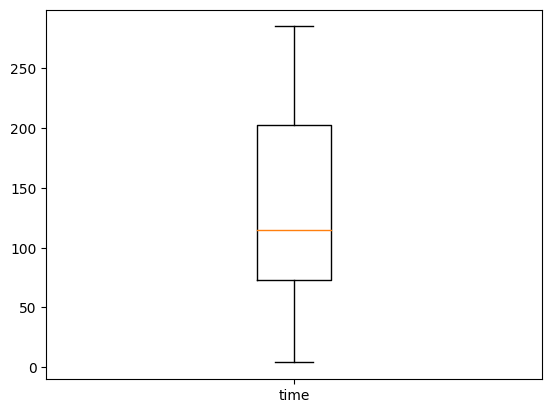

In [ ]:
# Box Plot
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

def box_p(att):
  plt.boxplot(heart[att], sym="bo")
  plt.xticks([1], [att])
  plt.show()

box_p('age')
box_p('creatinine_phosphokinase')
box_p('ejection_fraction')
box_p('platelets')
box_p('serum_creatinine')
box_p('serum_sodium')
box_p('time')

In [ ]:
from scipy.stats import shapiro

test_stats = []
p_vals = []

for var in conti_idx:
  test_stat, p_val = shapiro(heart.iloc[:,[var]])
  test_stats.append(test_stat)
  p_vals.append(p_val)

shapiro_test = pd.DataFrame({'test_statistic': test_stats, 'p_value': p_vals}, index=heart_conti.columns)
shapiro_test


,test_statistic,p_value
age,0.975470,5.350570e-05
creatinine_phosphokinase,0.514263,7.050336e-28
ejection_fraction,0.947316,7.215433e-09
platelets,0.911510,2.883745e-12
serum_creatinine,0.551466,5.392758e-27
serum_sodium,0.939026,9.210248e-10
time,0.946783,6.284611e-09


###Define outliers and remove them

In [ ]:
#데이터셋 크기가 너무 작아 1.5 대신 3 사용

def det_out(df, att, replace):
  q1=df[att].quantile(0.25)
  q3=df[att].quantile(0.75)
  iqr=q3-q1

  upper=df[att]>(q3+3*iqr)
  lower=df[att]<(q1-3*iqr)
  a = df[upper].index
  b = df[lower].index
  c = a.tolist() + b.tolist()
  if replace:
    df.drop(c,inplace=True)
    return df
  else:
    new = df.drop(c,inplace=False)
    return new

In [ ]:
col_list = heart_conti.columns.values.tolist()

for col in col_list:
  det_out(heart, col, True)
"""
box_p('age')
box_p('creatinine_phosphokinase')
box_p('ejection_fraction')
box_p('platelets')
box_p('serum_creatinine')
box_p('serum_sodium')
box_p('time')
p_sales
"""
heart.reset_index(inplace=True)
heart.drop(['index'], axis=1, inplace=True)
heart

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.0,1.9,130,1,0,4,1
1,65.0,0,146,0,20,0,162000.0,1.3,129,1,1,7,1
2,50.0,1,111,0,20,0,210000.0,1.9,137,1,0,7,1
3,65.0,1,160,1,20,0,327000.0,2.7,116,0,0,8,1
4,90.0,1,47,0,40,1,204000.0,2.1,132,1,1,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,52.0,0,190,1,38,0,382000.0,1.0,140,1,1,258,0
258,63.0,1,103,1,35,0,179000.0,0.9,136,1,1,270,0
259,62.0,0,61,1,38,1,155000.0,1.1,143,1,1,270,0
260,55.0,0,1820,0,38,0,270000.0,1.2,139,0,0,271,0


###Scatter plot

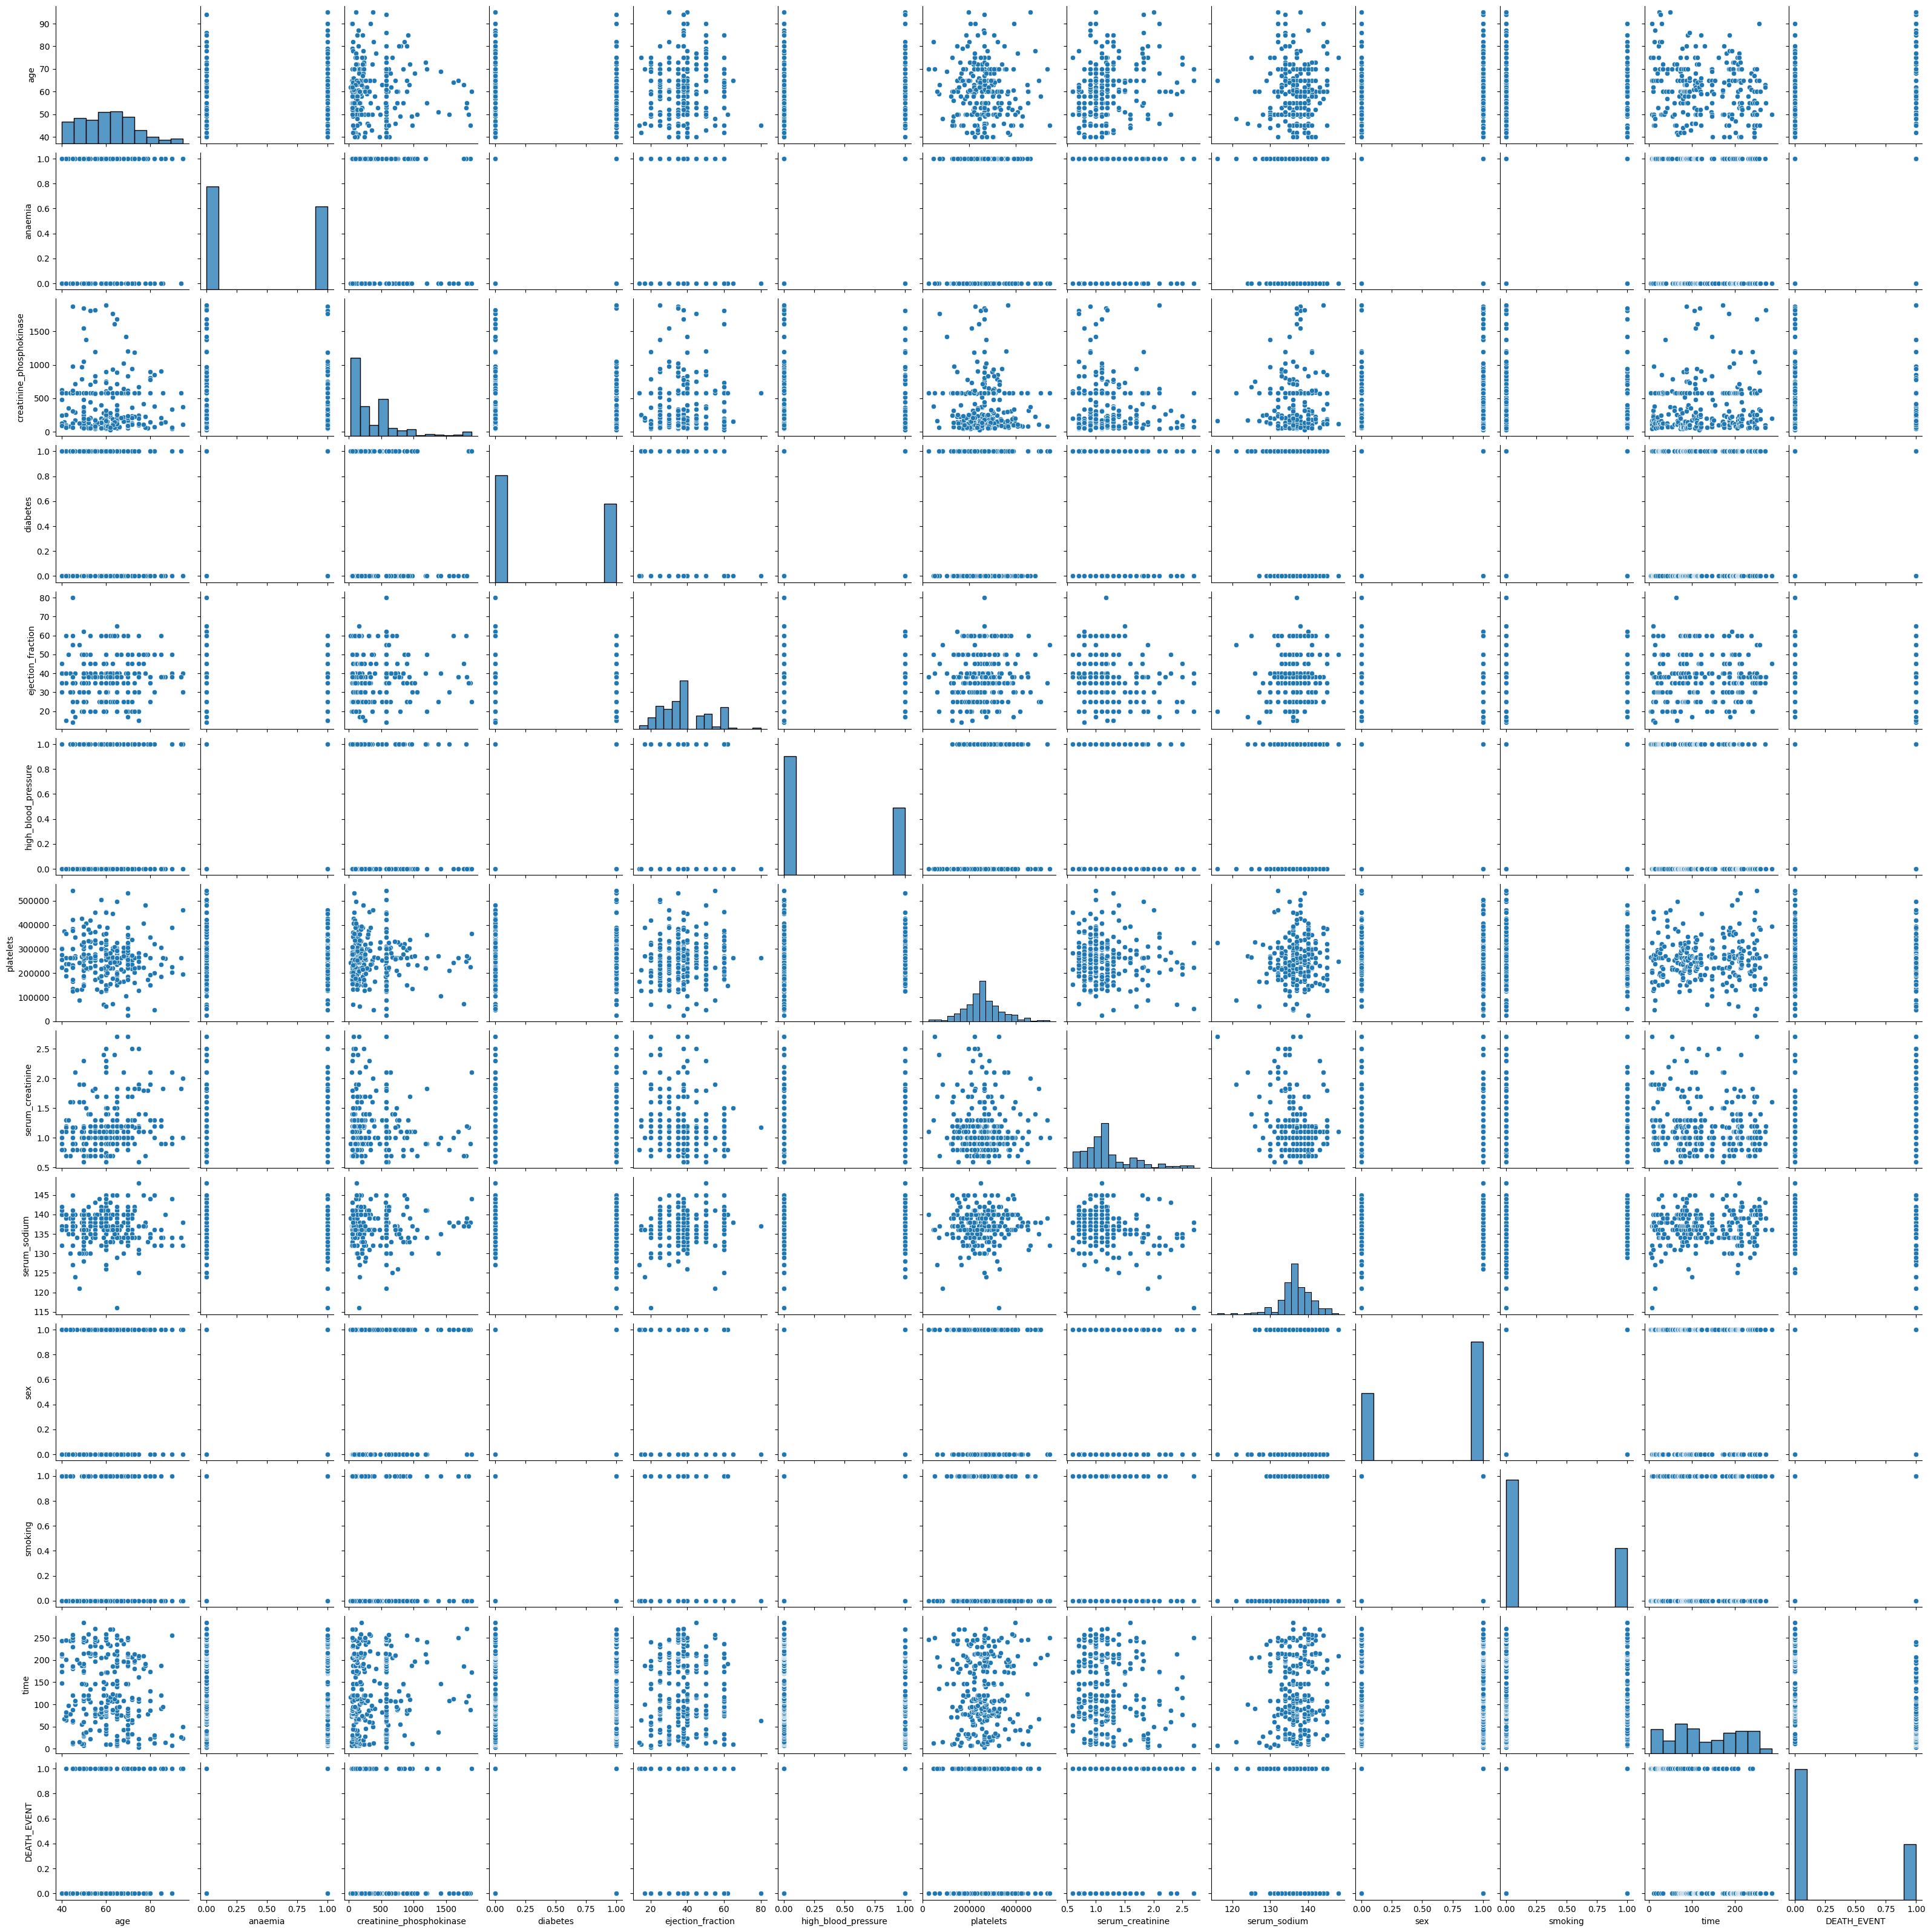

In [ ]:
import seaborn as sns
sns.pairplot(heart)

<Axes: >

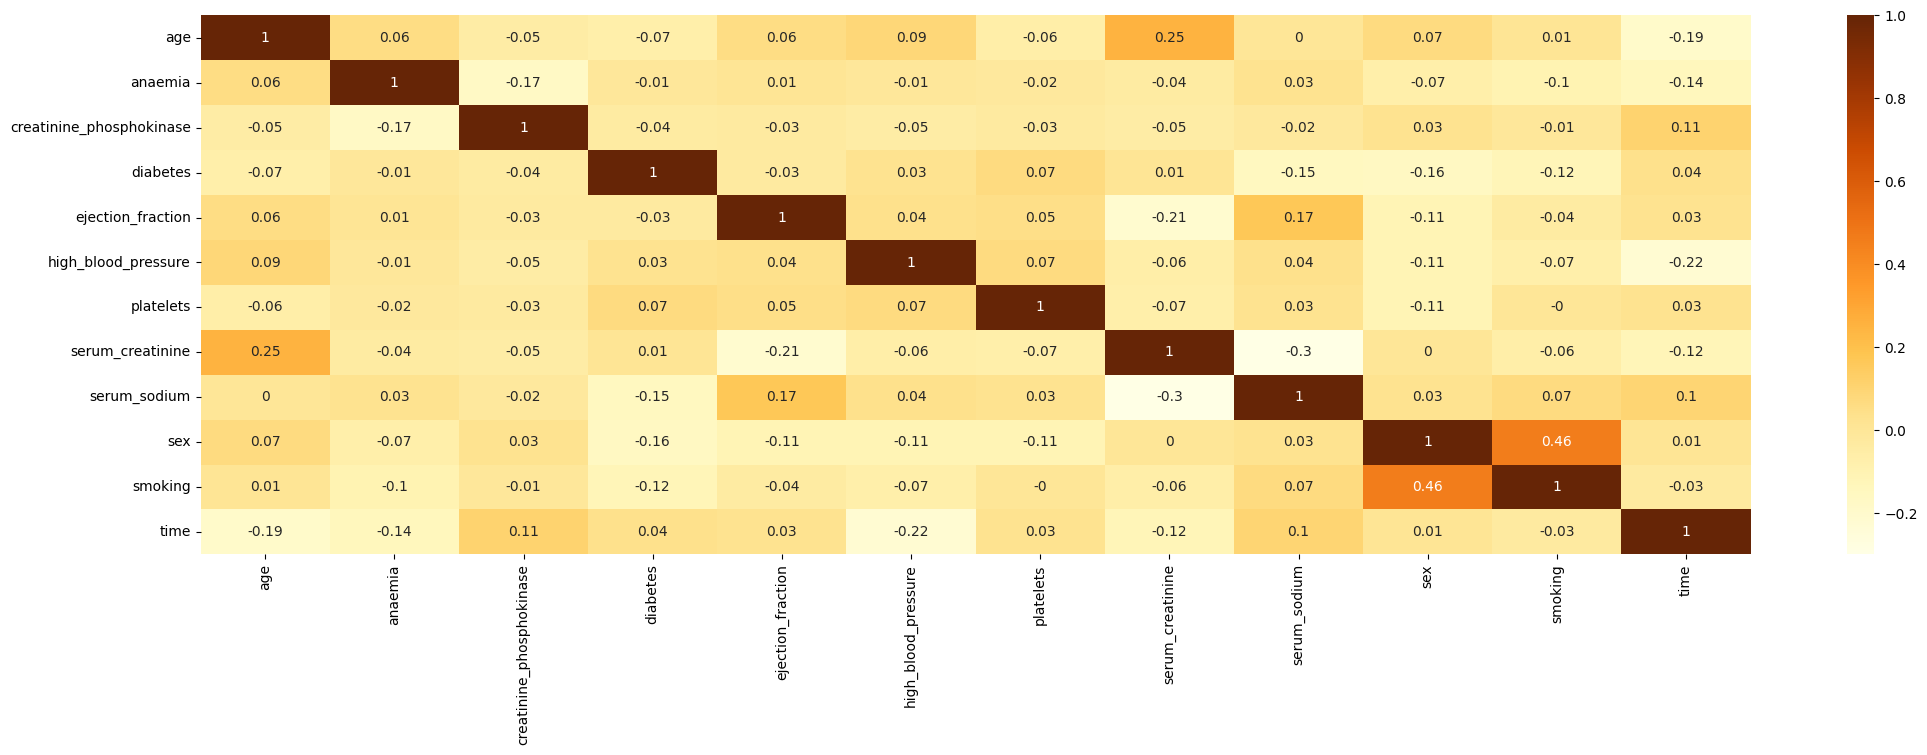

In [ ]:
heart_x=heart.iloc[:,:-1]
correlation = heart_x.corr().round(2)
plt.figure(figsize = (25,7))
sns.heatmap(correlation, annot = True, cmap = 'YlOrBr')

### Split the dataset
* 첫 1,500개 샘플을 학습용, 나머지 샘플을 검증용으로 구분
* Intercept가 없기 때문에 새로 설정  
    * statsmodels.tools.tools.add_constant  [[Link](https://www.statsmodels.org/stable/generated/statsmodels.tools.tools.add_constant.html#statsmodels.tools.tools.add_constant)]

In [ ]:
heart_trn = heart.iloc[:181,:]
heart_tst = heart.iloc[181:,:]

x_trn, y_trn = heart_trn.iloc[:,:-1],heart_trn.iloc[:,-1]
x_tst, y_tst = heart_tst.iloc[:,:-1],heart_tst.iloc[:,-1]

# feature names
feature_names = x_trn.columns.tolist()

### Logistic Regression
* 02_Logistic_Regression에서 활용한 scikit-learn의 모델 활용  
    * 주요 parameters  
        * penalty: 'l1'=LASSO, 'l2'=lasso, 'elasticnet'=Elastic Net 형성,'none':아무런 penalty 적용 안 함 
        * fit_intercept: 상수항 추가 여부 (default: True)  
        * solver: 최적의 해를 구하기 위한 알고리즘 선택 / 모든 penalty 종류에 적합한 'saga' 선택  
        * max_iter: solver가 수렴하기 위한 최대 시도 횟수  
        * n_jobs: 사용 되는 CPU 개수 / -1 : 모든 CPU 활용  
        * l1_ratio: Elastic Net 형성시 l1 penatly의 가중치([0,1]사이의 값이어야 함)  
        if) l1_ratio=0 : penalty='l2' , l1_ratio=1 : penalty:'l1'<br>
    <br>
* logit_pvalue 함수 이용하여 각 변수의 통계적 유의성 확인(*code Implemented from [[Here](https://pythonguides.com/scikit-learn-logistic-regression/)])

In [ ]:
from scipy.stats import norm
import scipy.stats as stats
def logit_pvalue(model,x,feature_names,cls=0):
    p1 = model.predict_proba(x)
    n1 = len(p1)
    m1 = len(model.coef_[cls]) + 1
    if len(model.intercept_)>1:
        feature_names=['constant'] + feature_names
        coefs = np.concatenate([np.array(model.intercept_[cls].reshape(1,)), model.coef_[cls]])
    elif len(model.intercept_)==1:
        feature_names=['constant'] + feature_names
        coefs = np.concatenate([model.intercept_, model.coef_[0]])
    else:
        coefs = model.coef_[cls]
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    answ = np.zeros((m1, m1))
    for i in range(n1):
        answ = answ + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p1[i,1] * p1[i, 0]
    vcov = np.linalg.inv(np.matrix(answ))
    se = np.sqrt(np.diag(vcov))
    t1 =  coefs/se  
    p1 = (1 - norm.cdf(abs(t1))) * 2
    pvalue_dict = {key:round(value,4) for key,value in zip(feature_names,p1)}
    display(pd.DataFrame(pvalue_dict,columns=pvalue_dict.keys(),index=['P-value']).T)

    return pvalue_dict

* 변수 선택 알고리즘이 적용된 모델의 결과 비교 실시  
    ```
    (1) 모든 변수(All Variables)  
    (2) Forward Selection  
    (3) stepwise Elimination  
    (4) Stepwise Selection  
    (5) Genetic Algorithm  
    (6) lasso Regression  
    (7) Lasso Regression  
    (8) Elastic Net
    ```  

#### 1) All Variables

In [ ]:
from sklearn.linear_model import LogisticRegression
seed = 1234
full_config = {
    'penalty':'none',
    'fit_intercept':True,
    'max_iter':10000,
    'solver':'saga',
    'random_state':seed,
    'n_jobs':-1
    
}
# Saving name of the selected features
features_dict = {}
features_dict['All Variables'] = ['constant']+feature_names # all Variables

full_model = LogisticRegression(**full_config).fit(x_trn,y_trn)
logit_pvalue(full_model,x_trn,feature_names)

y_pred = full_model.predict(x_tst)
result_dict['All Variables'] = perf_eval_clf(y_tst,y_pred)
display_coefs(full_model,'All_variables')
display_result(result_dict)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


,P-value
constant,1.0000
age,0.9990
anaemia,1.0000
creatinine_phosphokinase,0.8464
diabetes,1.0000
ejection_fraction,0.9977
high_blood_pressure,1.0000
platelets,0.5403
serum_creatinine,1.0000
serum_sodium,0.9996


Confusion Matrix:
[[76  0]
 [ 5  0]]
Model: All_variables


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,features,coefs
0,Constant,-1.128976e-07
1,age,1.630275e-05
2,anaemia,-9.104733e-09
3,creatinine_phosphokinase,-7.859636e-05
4,diabetes,1.392623e-07
5,ejection_fraction,-3.492579e-05
6,high_blood_pressure,9.934309e-08
7,platelets,-1.230711e-06
8,serum_creatinine,1.144222e-06
9,serum_sodium,-2.194060e-05


,TPR(Recall),Precision,TNR,ACC,BCR,F1
All Variables,0.0,0.0,1.0,0.938272,0.5,0.0


In [ ]:
def auroc(y,pred,name):
  return print('AUROC of {}: {}'.format(name, roc_auc_score(y, pred)))

In [ ]:
y_trn_pred = full_model.predict(x_trn)
auroc(y_tst, y_pred,'Test Data')
auroc(y_trn, y_trn_pred, 'Training Data')
perf_eval_clf(y_trn,y_trn_pred)

AUROC of Test Data: 0.5
AUROC of Training Data: 0.5
Confusion Matrix:
[[108   0]
 [ 73   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.0, 0.0, 1.0, 0.5966850828729282, 0.5, 0.0]

#### 2) Selected Variables

In [ ]:
x_trn_s = x_trn.drop(['age', 'sex'], axis=1)
x_tst_s = x_tst.drop(['age', 'sex'], axis=1)

In [ ]:
x_trn_s

,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,smoking,time
0,0,582,0,20,1,265000.0,1.9,130,0,4
1,0,146,0,20,0,162000.0,1.3,129,1,7
2,1,111,0,20,0,210000.0,1.9,137,0,7
3,1,160,1,20,0,327000.0,2.7,116,0,8
4,1,47,0,40,1,204000.0,2.1,132,1,8
...,...,...,...,...,...,...,...,...,...,...
176,0,97,0,60,1,220000.0,0.9,138,0,186
177,1,64,0,40,0,277000.0,0.7,137,1,187
178,1,167,1,45,0,362000.0,1.0,136,0,187
179,1,101,0,40,0,226000.0,0.8,141,0,187


In [ ]:
feature_names_s = ['anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'smoking', 'time']

In [ ]:
from sklearn.linear_model import LogisticRegression
seed = 1234
sel_config = {
    'penalty':'none',
    'fit_intercept':True,
    'max_iter':10000,
    'solver':'saga',
    'random_state':seed,
    'n_jobs':-1
    
}
# Saving name of the selected features
features_dict = {}
features_dict['Selected Variables'] = ['constant']+feature_names_s

sel_model = LogisticRegression(**sel_config).fit(x_trn_s,y_trn)
logit_pvalue(sel_model,x_trn_s,feature_names_s)

y_pred_s = sel_model.predict(x_tst_s)
result_dict['Selected Variables'] = perf_eval_clf(y_tst,y_pred_s)
display_coefs(sel_model,'Selected Variables')
display_result(result_dict)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


,P-value
constant,1.0000
anaemia,1.0000
creatinine_phosphokinase,0.8450
diabetes,1.0000
ejection_fraction,0.9977
high_blood_pressure,1.0000
platelets,0.5398
serum_creatinine,1.0000
serum_sodium,0.9996
smoking,1.0000


Confusion Matrix:
[[76  0]
 [ 5  0]]
Model: Selected Variables


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,features,coefs
0,Constant,-1.127486e-07
1,anaemia,-9.011492e-09
2,creatinine_phosphokinase,-7.854759e-05
3,diabetes,1.392958e-07
4,ejection_fraction,-3.492003e-05
5,high_blood_pressure,9.940399e-08
6,platelets,-1.227154e-06
7,serum_creatinine,1.144444e-06
8,serum_sodium,-2.192025e-05
9,smoking,1.102213e-08


,TPR(Recall),Precision,TNR,ACC,BCR,F1
All Variables,0.0,0.0,1.0,0.938272,0.5,0.0
Selected Variables,0.0,0.0,1.0,0.938272,0.5,0.0


In [ ]:
y_trn_pred_s = sel_model.predict(x_trn_s)
auroc(y_tst, y_pred_s,'Test Data')
auroc(y_trn, y_trn_pred_s, 'Training Data')
perf_eval_clf(y_trn,y_trn_pred_s)

AUROC of Test Data: 0.5
AUROC of Training Data: 0.5
Confusion Matrix:
[[108   0]
 [ 73   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.0, 0.0, 1.0, 0.5966850828729282, 0.5, 0.0]

#### 2) Forward Selection

* scikit-learn의 SequentialFeatureSelector 활용 [[Link]](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html#sklearn.feature_selection.SequentialFeatureSelector)

* 주요 Parameters
    * estimator: scikit-learnd의 model / 1)의 Logisitic regression 활용
    * n_features: 선택되는 변수의 수 / 'auto'로 설정하면 자동으로 변수 선택 됨 / 특정 숫자(정수)로 지정 가능  
    * tol: 변수의 선택/제거 후의 모델의 성능과 이전 시점의 모델과의 성능이 최소 tol 만큼 차이가 존재할 시 변수의 선택/제거가 실시됨 / n_features 가 'auto'일 때 설정이 필요함
    * **direction: 'forward'=Forward Selection / 'backward'=Backward Elimination 진행**
    * scoring: 모델의 성능 평가 지표 / 분류 과업일 시 'f1'으로 설정하는 것이 일반적
    * cv: Cross-validation을 실시할 때의 fold 개수 / 아무 값도 입력하지 않을 시 5-fold로 진행 됨 <br>
<br>

* SequentialFeatureSelector.fit() 활용하여 변수 선택 후, 선택된 변수로 Logistic Regression 학습 진행

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from scipy import *
import time

# SequentialFeatureSelector 학습
full_config = {
    'penalty':'none',
    'fit_intercept':True,
    'max_iter':10000,
    'solver':'saga',
    'random_state':seed,
    'n_jobs':-1
    
}
full_model = LogisticRegression(**full_config)

forward_config = {
    'estimator':full_model,
    'n_features_to_select':'auto',
    'tol':10000,
    'direction':'forward',
    'scoring':'f1',
    'cv':5,
    'n_jobs':-1
}
t1 = time.time()
forward_selection = SFS(**forward_config).fit(x_trn,y_trn)
t2 = time.time()
features_dict['Forward Selection']=forward_features = forward_selection.get_feature_names_out()

print(forward_features)

['ejection_fraction']


In [ ]:
print('Time elapsed: {}'.format(t2-t1))

Time elapsed: 6.203265428543091


In [ ]:
# Training Logistic Regression with selected features

x_trn_forward = x_trn[forward_features]
x_tst_forward = x_tst[forward_features]
forward_logit = LogisticRegression(**full_config).fit(x_trn_forward,y_trn)

y_pred = forward_logit.predict(x_tst_forward)
result_dict['Forward Selection'] = perf_eval_clf(y_tst,y_pred)
display_coefs(forward_logit,'Forward Selection')
display_result(result_dict)

Confusion Matrix:
[[69  7]
 [ 2  3]]
Model: Forward Selection


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


,features,coefs
0,Constant,1.558828
1,ejection_fraction,-0.052597


,TPR(Recall),Precision,TNR,ACC,BCR,F1
All Variables,0.0,0.0,1.000,0.938272,0.500000,0.0
Selected Variables,0.0,0.0,1.000,0.938272,0.500000,0.0
Forward Selection,0.6,0.3,0.908,0.888889,0.753947,0.4


In [ ]:
y_trn_pred = forward_logit.predict(x_trn_forward)
auroc(y_tst, y_pred,'Test Data')
auroc(y_trn, y_trn_pred, 'Training Data')

AUROC of Test Data: 0.7539473684210527
AUROC of Training Data: 0.656773211567732


#### 3) Backward Elimination

In [ ]:
# SequentialFeatureSelector 학습
full_config = {
    'penalty':'none',
    'fit_intercept':True,
    'max_iter':10000,
    'solver':'saga',
    'random_state':seed,
    'n_jobs':-1
    
}
full_model = LogisticRegression(**full_config)

backward_config = {
    'estimator':full_model,
    'n_features_to_select':'auto',
    'tol':10000,
    'direction':'backward',
    'scoring':'f1',
    'cv':5,
    'n_jobs':-1
}
t1 = time.time()
backward_eliminaion = SFS(**backward_config).fit(x_trn,y_trn)
t2 = time.time()
features_dict['Backward Elimination'] = backward_features = backward_eliminaion.get_feature_names_out()
print(backward_features)

['age' 'anaemia' 'creatinine_phosphokinase' 'diabetes' 'ejection_fraction'
 'high_blood_pressure' 'serum_creatinine' 'serum_sodium' 'sex' 'smoking'
 'time']


In [ ]:
print('Time elapsed: {}'.format(t2-t1))

Time elapsed: 22.662732362747192


In [ ]:
# Training Logistic Regression with selected features

x_trn_backward = x_trn[backward_features]
x_tst_backward = x_tst[backward_features]
backward_logit = LogisticRegression(**full_config).fit(x_trn_backward,y_trn)

y_pred = backward_logit.predict(x_tst_backward)
result_dict['Backward Elimination'] = perf_eval_clf(y_tst,y_pred)
display_coefs(backward_logit,'Backward Elimination')
display_result(result_dict)

Confusion Matrix:
[[76  0]
 [ 5  0]]
Model: Backward Elimination


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,features,coefs
0,Constant,0.000311
1,age,0.062736
2,anaemia,-0.000420
3,creatinine_phosphokinase,0.000364
4,diabetes,0.002261
5,ejection_fraction,-0.068162
6,high_blood_pressure,-0.001004
7,serum_creatinine,0.009965
8,serum_sodium,0.000362
9,sex,-0.001874


,TPR(Recall),Precision,TNR,ACC,BCR,F1
All Variables,0.0,0.0,1.000,0.938272,0.500000,0.0
Selected Variables,0.0,0.0,1.000,0.938272,0.500000,0.0
Forward Selection,0.6,0.3,0.908,0.888889,0.753947,0.4
Backward Elimination,0.0,0.0,1.000,0.938272,0.500000,0.0


In [ ]:
y_trn_pred = backward_logit.predict(x_trn_backward)
auroc(y_tst, y_pred,'Test Data')
auroc(y_trn, y_trn_pred, 'Training Data')

AUROC of Test Data: 0.5
AUROC of Training Data: 0.791349568746829


#### 4) Stepwise Selection

* scikit-learn의 SequentialFeatureSelector의 parameter 중 ```direction='forward', tol=None```으로 설정할 시 Stepwise Selection의 알고리즘을 따르게 됨


In [ ]:
# SequentialFeatureSelector 학습
full_config = {
    'penalty':'none',
    'fit_intercept':True,
    'max_iter':10000,
    'solver':'saga',
    'random_state':seed,
    'n_jobs':-1
    
}
full_model = LogisticRegression(**full_config)

stepwise_config = {
    'estimator':full_model,
    'n_features_to_select':'auto',
    'tol':None,
    'direction':'forward',
    'scoring':'f1',
    'cv':5,
    'n_jobs':-1
}
t1 = time.time()
stepwise_selection = SFS(**stepwise_config).fit(x_trn,y_trn)
t2 = time.time()
features_dict['Stepwise Selection']= stepwise_features = stepwise_selection.get_feature_names_out()

print(stepwise_features)

['age' 'anaemia' 'ejection_fraction' 'high_blood_pressure'
 'serum_creatinine' 'smoking']


In [ ]:
print('Time elapsed: {}'.format(t2-t1))

Time elapsed: 16.390979051589966


In [ ]:
# Training Logistic Regression with selected features

x_trn_stepwise = x_trn[stepwise_features]
x_tst_stepwise = x_tst[stepwise_features]
stepwise_logit = LogisticRegression(**full_config).fit(x_trn_stepwise,y_trn)

y_pred = stepwise_logit.predict(x_tst_stepwise)
result_dict['Stepwise Selection'] = perf_eval_clf(y_tst,y_pred)
display_coefs(stepwise_logit,'Stepwise Selection')
display_result(result_dict)

Confusion Matrix:
[[62 14]
 [ 0  5]]
Model: Stepwise Selection


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


,features,coefs
0,Constant,-0.876262
1,age,0.029930
2,anaemia,-0.072260
3,ejection_fraction,-0.073488
4,high_blood_pressure,0.141545
5,serum_creatinine,1.135558
6,smoking,-0.003003


,TPR(Recall),Precision,TNR,ACC,BCR,F1
All Variables,0.0,0.000000,1.000,0.938272,0.500000,0.000000
Selected Variables,0.0,0.000000,1.000,0.938272,0.500000,0.000000
Forward Selection,0.6,0.300000,0.908,0.888889,0.753947,0.400000
Backward Elimination,0.0,0.000000,1.000,0.938272,0.500000,0.000000
Stepwise Selection,1.0,0.263158,0.816,0.827160,0.907895,0.416667


In [ ]:
y_trn_pred = stepwise_logit.predict(x_trn_stepwise)
auroc(y_tst, y_pred,'Test Data')
auroc(y_trn, y_trn_pred, 'Training Data')

AUROC of Test Data: 0.9078947368421052
AUROC of Training Data: 0.7571029934043633


#### 5) Genetic Algorithm

* Implemented from [[Here](https://www.kaggle.com/code/tanmayunhale/genetic-algorithm-for-feature-selection)]
* Functions in the class
    * initialization_of_population: To initialize a random population
    * fitness_scores: Returns the best parents along with their score(Since we are conducting classcification, we are going to compare the f1-score)
    * selection: Selection of the best parents
    * crossover: Take genes from the selected parents
    * mutation: Randomly flips selected bits from the crossover child
    * fit: Perform the whole process for the specified number of generations

![GA_Process]('GA_process.png')

In [ ]:
from sklearn.metrics import f1_score

class GeneticAlgorithm(object):
    def __init__(self, 
    population_size: int,
    n_feat: int, 
    n_parents: int,
    n_gen: int,
    init_rate: float,
    mutation_rate:float,
    crossover_rate:float,
    model:object,
    seed: int

    ) -> None:
        """
        population_size: (int) size of population
        n_feat: (int) number of total features
        n_parents: (int) number of parents chromosomes
        n_gen: (int) number of generations
        init_rate: (float) fraction of non-selected features
        mutation_rate: (float) probability of generating mutation
        crossover_rate: (float) probability of doing cross over on each variable
        model: classification models of sckit-learn
        seed: (int) set the randomness

        """
        self.population_size = population_size
        self.n_feat = n_feat
        self.n_parents = n_parents
        self.n_gen = n_gen
        self.init_rate = init_rate
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.model = model
        self.seed = seed
    
    def initialization_of_population(self,size: int, n_feat: int, init_prob: float)->list:

        population = []
        for i in range(size):
            chromosome = np.bool_(np.ones(n_feat-1))
            chromosome[:int(init_prob*n_feat)]=False             
            np.random.shuffle(chromosome) # 선택되는 feature의 비율을 정한 후 무작위로 선택
            population.append(chromosome)
        
        return population


    def fitness_score(self, model, population:list, X_train:Union[np.array,pd.DataFrame],Y_train:Union[np.array,pd.DataFrame]):
        scores = []
        for chromosome in population:
            model.fit(X_train.iloc[:,chromosome],Y_train)         
            predictions = model.predict(X_train.iloc[:,chromosome])
            scores.append(f1_score(Y_train,predictions))
        scores, population = np.array(scores), np.array(population) 
        inds = np.argsort(scores)                                    
        return list(scores[inds][::-1]), list(population[inds,:][::-1]) 

    def selection(self,pop_after_fit,n_parents):
        population_nextgen = []
        for i in range(n_parents):
            population_nextgen.append(pop_after_fit[i])
        return population_nextgen


    def crossover(self,pop_after_sel:list,crossover_rate:float):
        pop_nextgen = pop_after_sel
        for i in range(0,len(pop_after_sel),2):
            new_par = []
            child_1 , child_2 = pop_nextgen[i] , pop_nextgen[i+1]   
            new_par = []
            select_idx = np.random.random_sample(len(child_1)) > crossover_rate
            for j in range(len(child_1)):
                new_par.append(child_1[j] if select_idx[j] else child_2[j])
            pop_nextgen.append(new_par)
        return pop_nextgen

    def mutation(self, pop_after_cross:list, mutation_rate:float, n_feat:int):   
        mutation_range = int(mutation_rate*n_feat)
        pop_next_gen = []
        for n in range(0,len(pop_after_cross)):
            chromo = pop_after_cross[n]
            rand_posi = []
            for i in range(0,mutation_range):
                pos = np.random.randint(0,n_feat-1)
                rand_posi.append(pos)
            for j in rand_posi:
                chromo[j] = not chromo[j]  
            pop_next_gen.append(chromo)
        return pop_next_gen

    def fit(self,
            x_trn:Union[np.array, pd.DataFrame],
            y_trn:Union[np.array, pd.Series,list,],
            x_tst:Union[np.array, pd.DataFrame],
            y_tst:Union[np.array, pd.Series,list]):
        
        np.random.seed(self.seed)
        best_chromo= []
        best_score= []
        population_nextgen = self.initialization_of_population(self.population_size, self.n_feat, self.init_rate)
        for i in range(self.n_gen):
            scores, pop_after_fit = self.fitness_score(
                self.model,
                population_nextgen,
                x_trn, y_trn
                )
            print('Best score(Training) in generation',i+1,':',scores[:1])  #2
            pop_after_sel = self.selection(pop_after_fit,self.n_parents)
            pop_after_cross = self.crossover(pop_after_sel,self.crossover_rate)
            population_nextgen = self.mutation(pop_after_cross, self.mutation_rate, self.n_feat)
            best_chromo.append(pop_after_fit[0])
            best_score.append(scores[0])
        return best_chromo, best_score

In [ ]:
seed = 1234
full_config = {
    'penalty':'none',
    'fit_intercept':True,
    'max_iter':10000,
    'solver':'saga',
    'random_state':seed,
    'n_jobs':-1,

    
}
full_model = LogisticRegression(**full_config)

genetic_config={
    'population_size':20,
    'n_feat':max_features,
    'n_parents':2,
    'n_gen':5,
    'init_rate':0.3,
    'mutation_rate':0.1,
    'crossover_rate':0.3,
    'model':full_model,
    'seed':seed
}

GA = GeneticAlgorithm(**genetic_config)
t1 = time.time()
bestchromo,bestscores = GA.fit(x_trn,y_trn,x_tst,y_tst)
t2 = time.time()
features_dict['Genetic Algorithm'] = genetic_features = np.array(feature_names)[bestchromo[np.argmax(bestscores)]].tolist()
print(genetic_features)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:11

Best score(Training) in generation 1 : [0.7482014388489209]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:11

Best score(Training) in generation 2 : [0.7482014388489209]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Best score(Training) in generation 3 : [0.7482014388489209]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Best score(Training) in generation 4 : [0.7482014388489209]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Best score(Training) in generation 5 : [0.7058823529411765]
['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'serum_sodium', 'sex', 'smoking', 'time']


In [ ]:
print('Time elapsed: {}'.format(t2-t1))

Time elapsed: 8.40589189529419


In [ ]:
# Training Logistic Regression with selected features

x_trn_genetic = x_trn[genetic_features]
x_tst_genetic = x_tst[genetic_features]
genetic_logit = LogisticRegression(**full_config).fit(x_trn_genetic,y_trn)

y_pred = genetic_logit.predict(x_tst_genetic)
result_dict['Genetic Algorithm'] = perf_eval_clf(y_tst,y_pred)
display_coefs(genetic_logit,'Genetic Algorithm')
display_result(result_dict)

Confusion Matrix:
[[76  0]
 [ 5  0]]
Model: Genetic Algorithm


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,features,coefs
0,Constant,0.000312
1,age,0.062846
2,anaemia,-0.000421
3,creatinine_phosphokinase,0.000363
4,diabetes,0.002269
5,ejection_fraction,-0.068232
6,high_blood_pressure,-0.001009
7,serum_sodium,0.000423
8,sex,-0.001883
9,smoking,-0.000717


,TPR(Recall),Precision,TNR,ACC,BCR,F1
All Variables,0.0,0.000000,1.000,0.938272,0.500000,0.000000
Selected Variables,0.0,0.000000,1.000,0.938272,0.500000,0.000000
Forward Selection,0.6,0.300000,0.908,0.888889,0.753947,0.400000
Backward Elimination,0.0,0.000000,1.000,0.938272,0.500000,0.000000
Stepwise Selection,1.0,0.263158,0.816,0.827160,0.907895,0.416667
Genetic Algorithm,0.0,0.000000,1.000,0.938272,0.500000,0.000000


In [ ]:
y_trn_pred = genetic_logit.predict(x_trn_genetic)
auroc(y_tst, y_pred,'Test Data')
auroc(y_trn, y_trn_pred, 'Training Data')

AUROC of Test Data: 0.5
AUROC of Training Data: 0.791349568746829


#### Genetic Algorithm Hyperparameter Test

* Population size = {20, 40, 60}
* Cross-over rate = {0.3, 0.5, 0.7}
* Mutation rate = {0.1, 0.3, 0.5}

In [ ]:
seed = 1234
full_config = {
    'penalty':'none',
    'fit_intercept':True,
    'max_iter':10000,
    'solver':'saga',
    'random_state':seed,
    'n_jobs':-1,

    
}
full_model = LogisticRegression(**full_config)

,population size,cross-over rate,mutation rate,attributes


In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [ ]:
def GA_please(ps, cr, mr):
  genetic_config['population_size'] = ps
  genetic_config['crossover_rate'] = cr
  genetic_config['mutation_rate'] = mr

  GA = GeneticAlgorithm(**genetic_config)
  bestchromo,bestscores = GA.fit(x_trn,y_trn,x_tst,y_tst)
  features_dict['Genetic Algorithm'] = genetic_features = np.array(feature_names)[bestchromo[np.argmax(bestscores)]].tolist()
  return print('\nPopulation Size: {}, Crossover Rate: {}, Mutation Rate: {}\nAttributes: {}\n'.format(genetic_config.get('population_size'),genetic_config.get('crossover_rate'),genetic_config.get('mutation_rate'),genetic_features))

In [ ]:
GA_please(20, 0.3, 0.1)
GA_please(20, 0.3, 0.3)
GA_please(20, 0.3, 0.5)
GA_please(20, 0.5, 0.1)
GA_please(20, 0.5, 0.3)
GA_please(20, 0.5, 0.5)
GA_please(20, 0.7, 0.1)
GA_please(20, 0.7, 0.3)
GA_please(20, 0.7, 0.5)

Best score(Training) in generation 1 : [0.7482014388489209]
Best score(Training) in generation 2 : [0.7482014388489209]
Best score(Training) in generation 3 : [0.7482014388489209]
Best score(Training) in generation 4 : [0.7482014388489209]
Best score(Training) in generation 5 : [0.7058823529411765]

Population Size: 20, Crossover Rate: 0.3, Mutation Rate: 0.1
Attributes: ['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'serum_sodium', 'sex', 'smoking', 'time']

Best score(Training) in generation 1 : [0.7482014388489209]
Best score(Training) in generation 2 : [0.7746478873239437]
Best score(Training) in generation 3 : [0.7482014388489209]
Best score(Training) in generation 4 : [0.7591240875912408]
Best score(Training) in generation 5 : [0.7482014388489209]

Population Size: 20, Crossover Rate: 0.3, Mutation Rate: 0.3
Attributes: ['age', 'anaemia', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine'

In [ ]:
GA_please(40, 0.3, 0.1)
GA_please(40, 0.3, 0.3)
GA_please(40, 0.3, 0.5)
GA_please(40, 0.5, 0.1)
GA_please(40, 0.5, 0.3)
GA_please(40, 0.5, 0.5)
GA_please(40, 0.7, 0.1)
GA_please(40, 0.7, 0.3)
GA_please(40, 0.7, 0.5)

Best score(Training) in generation 1 : [0.7482014388489209]
Best score(Training) in generation 2 : [0.7482014388489209]
Best score(Training) in generation 3 : [0.7482014388489209]
Best score(Training) in generation 4 : [0.7482014388489209]
Best score(Training) in generation 5 : [0.7482014388489209]

Population Size: 40, Crossover Rate: 0.3, Mutation Rate: 0.1
Attributes: ['age', 'anaemia', 'creatinine_phosphokinase', 'ejection_fraction', 'serum_sodium', 'sex', 'smoking', 'time']

Best score(Training) in generation 1 : [0.7482014388489209]
Best score(Training) in generation 2 : [0.7482014388489209]
Best score(Training) in generation 3 : [0.0]
Best score(Training) in generation 4 : [0.6071428571428571]
Best score(Training) in generation 5 : [0.6771653543307086]

Population Size: 40, Crossover Rate: 0.3, Mutation Rate: 0.3
Attributes: ['age', 'anaemia', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_sodium', 'sex', 'smoking']

Best score(Training) in generation 1 : [

In [ ]:
GA_please(60, 0.3, 0.1)
GA_please(60, 0.3, 0.3)
GA_please(60, 0.3, 0.5)
GA_please(60, 0.5, 0.1)
GA_please(60, 0.5, 0.3)
GA_please(60, 0.5, 0.5)
GA_please(60, 0.7, 0.1)
GA_please(60, 0.7, 0.3)
GA_please(60, 0.7, 0.5)

Best score(Training) in generation 1 : [0.7482014388489209]
Best score(Training) in generation 2 : [0.7058823529411765]
Best score(Training) in generation 3 : [0.7058823529411765]
Best score(Training) in generation 4 : [0.7445255474452555]
Best score(Training) in generation 5 : [0.6906474820143884]

Population Size: 60, Crossover Rate: 0.3, Mutation Rate: 0.1
Attributes: ['age', 'anaemia', 'creatinine_phosphokinase', 'ejection_fraction', 'high_blood_pressure', 'serum_sodium', 'sex', 'smoking']

Best score(Training) in generation 1 : [0.7482014388489209]
Best score(Training) in generation 2 : [0.7482014388489209]
Best score(Training) in generation 3 : [0.7482014388489209]
Best score(Training) in generation 4 : [0.7482014388489209]
Best score(Training) in generation 5 : [0.6176470588235294]

Population Size: 60, Crossover Rate: 0.3, Mutation Rate: 0.3
Attributes: ['age', 'anaemia', 'creatinine_phosphokinase', 'high_blood_pressure', 'platelets', 'serum_sodium', 'sex', 'smoking']

Best sco

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best score(Training) in generation 3 : [0.7058823529411765]
Best score(Training) in generation 4 : [0.7205882352941178]
Best score(Training) in generation 5 : [0.7536231884057971]

Population Size: 60, Crossover Rate: 0.7, Mutation Rate: 0.5
Attributes: ['age', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'smoking', 'time']

